# Random Forest Model

Binary classifier of SBS04 and SBS13  
15 bp on either side of the mutation  
k-mers = 4  

### Load Packages in R

In [3]:
library(Biostrings)
library(dplyr)
library(ggplot2)
library(BSgenome)
library(GenomicRanges)
library(reshape2)
library(xtable)
library(tidyr)
library(randomForest)
library(caret)
library(PRROC)
library(pROC)
library(Rtsne)
library(pheatmap)
# library(iml)
# library(shapr)
library(ranger)
library(kernelshap)
library(shapviz)
library(BSgenome.Hsapiens.UCSC.hg19)

#get workdir
getwd()

[1] "/.mounts/labs/reimandlab/private/users/k2zhang"

### Load Data and Count SBS Signatre for the data 

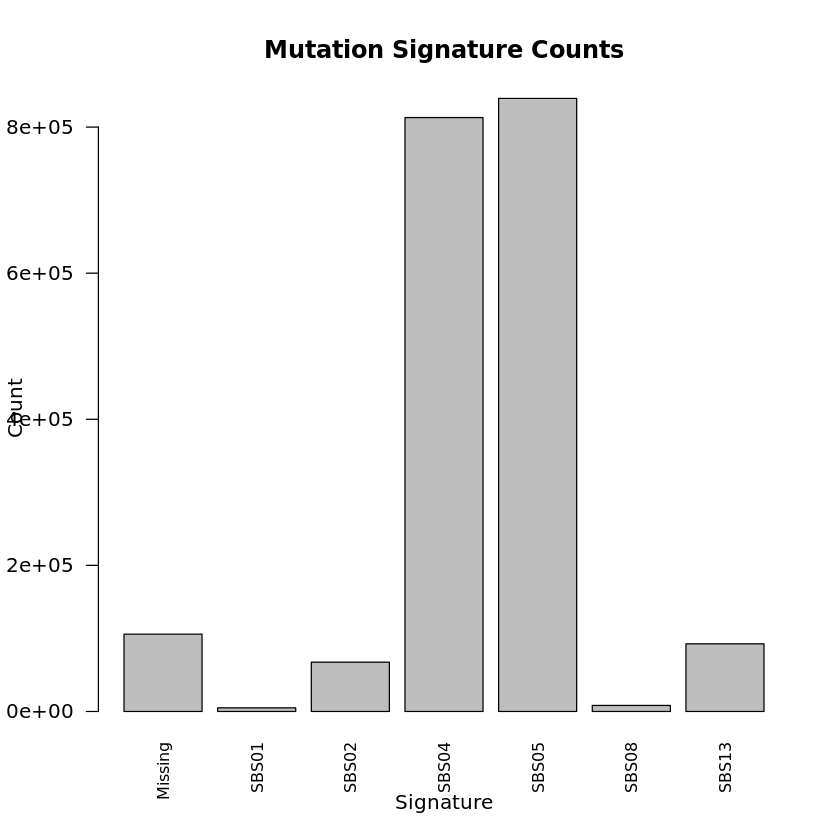

In [4]:
# Read mutation file
mutation_file <- "./PCAWG/lung_scc_muts_final.txt"
mutations <- read.table(mutation_file, header = TRUE, stringsAsFactors = FALSE, row.names = NULL)
# Read SBS signature file
sbs_file <- "./PCAWG/lung_scc_sig_final.txt"
sbs_signatures <- readLines(sbs_file)
# Combine the mutation data and signature data into a single dataframe
combined_data <- data.frame(mutations, Signature = sbs_signatures)
# combined_data <- head(combined_data, 1000)
#How many mutation in the SBS signature
# Modify the Signature column
combined_data$Signature <- ifelse(combined_data$Signature == "-", "Missing", paste0("SBS", combined_data$Signature))
# Count the number of mutations in each SBS signature
signature_counts <- table(combined_data$Signature)
# Display the counts
# print(signature_counts)
# Bar plot for mutation signature counts
barplot(signature_counts, 
        main = "Mutation Signature Counts", 
        xlab = "Signature", 
        ylab = "Count", 
        las = 2,          # Rotate labels to be perpendicular to the axis
        cex.names = 0.8)  # Adjust text size of labels

Using the barplot above, isolate for the two most abundant, or the two most distinct SBS signatures. That will be used for the binary classifier

### Retrieve Flanking Sequences

The genomicRanges R package will be used

For this example, 15 bp on either side will be used

In [5]:
# Get hg19 reference sequence of GRanges object
get_hg19_seq <- function(gr, return.DNAStringSet = FALSE) {
  if (return.DNAStringSet) {
    return(BSgenome::getSeq(BSgenome.Hsapiens.UCSC.hg19::Hsapiens, gr))
  } else {
    return(as.character(BSgenome::getSeq(BSgenome.Hsapiens.UCSC.hg19::Hsapiens, gr)))
  }
}
# Create a GRanges object from mutation data
mutations_gr <- GRanges(seqnames = combined_data$chr,
                         ranges = IRanges(start = combined_data$start - 15,
                                          end = combined_data$end + 15))
# Extract sequences
mutation_sequences <- get_hg19_seq(mutations_gr, return.DNAStringSet = TRUE)
# Create names for the sequences
sequence_names <- paste(combined_data$chr, combined_data$start, combined_data$end, sep = ":")
# Assign the names to the sequences
names(mutation_sequences) <- sequence_names
# Save sequences to a file
# writeXStringSet(mutation_sequences, filepath = "mutation_sequences.fa")
# Convert DNAStringSet to a character vector
mutation_sequence_vector <- as.character(mutation_sequences)
# Add this vector as a new column to combined_data
combined_data$sequences <- mutation_sequence_vector

head(combined_data)

,row.names,chr,start,end,ref,alt,Signature,sequences
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,1,chr1,767037,767037,C,T,SBS05,AGTCATAAATAAACACGATGAATCTATGTAG
2,2,chr1,891028,891028,C,T,SBS05,CTAACCTGGGAAAATCTGAGAGCAAAGGCAG
3,3,chr1,1057606,1057606,C,A,SBS04,ACAGGCTGGGGCATCCGCGGACCCTCGTCTC
4,4,chr1,1123017,1123017,A,G,SBS05,TCCATCTCAAAAAACAAAAAAATAAAAATCC
5,5,chr1,2795286,2795286,C,T,SBS05,CCCTCTGGCCCCTCGCACACAAGCATGGCCA
6,6,chr1,2799999,2799999,G,T,SBS04,GGCTGAGGCTGCCTGGCCCTGCTGGGACCCT


### Filter Data

In [6]:
set.seed(2024)

# Determine the minimum number of occurrences between SBS013 and SBS04
min_count <- min(sum(combined_data$Signature == "SBS13"), sum(combined_data$Signature == "SBS04"))

# Sample the same number of rows for each signature
subset_sbs13 <- combined_data[combined_data$Signature == "SBS13", ]
subset_sbs04 <- combined_data[combined_data$Signature == "SBS04", ]

# Downsample or upsample to the smaller class size
subset_sbs13 <- subset_sbs13[sample(nrow(subset_sbs13), min_count), ]
subset_sbs04 <- subset_sbs04[sample(nrow(subset_sbs04), min_count), ]

# Combine the two balanced subsets
subset_data <- rbind(subset_sbs13, subset_sbs04)

# Randomly sample 100,000 rows from the balanced data
subset_data <- subset_data[sample(nrow(subset_data), 185100), ]

# Check the last 10 rows
tail(subset_data, 10)

,row.names,chr,start,end,ref,alt,Signature,sequences
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1835410,48732,chrX,20120801,20120801,G,C,SBS13,ACTGGTGAGGCTCTAGATGACAGAGTCTGAC
606637,19478,chr5,6080645,6080645,G,T,SBS04,GGGAAAAAGACCATAGCTCGGGTCTCGGGGA
1689504,40125,chr5,25248544,25248544,C,A,SBS04,CTGGGGTTCCCAGTCCTTGGCCCCCTTACCT
1376139,21048,chr17,1678227,1678227,G,C,SBS13,TTCCCTGAGGCCTCAGAGCCCCTGACAGCTA
281158,7592,chr13,69383505,69383505,C,G,SBS04,GCCTGGGCGACAAAGCGAGACTCCGTCTCAA
1284459,32525,chr4,1767259,1767259,C,G,SBS13,TAGCAAGCTCCTATTCACCCCTGAAGACCCA
1675185,25806,chr2,90032906,90032906,C,G,SBS13,CAACCGACTTTACTTCATCTCTTTATCAGCT
1724984,14493,chr20,59632613,59632613,G,C,SBS13,AGAGGGCTCACAGCAGAATCGCAGCTTCCAC
523720,23076,chrX,87349754,87349754,C,A,SBS04,TTGACGGGTCTTTTCCTTTTTTTCTGATAAA


### Generate K-mers

Testing with all features as a reference. 

```generate_canonical_kmers```: function to generate kmers; accounts for compliments using the ```reverseComplement``` function  
```k <- 4```: k is set to 4 in this example  
```encoded_kmers```: encode k-mers as vectors   


In [7]:
generate_canonical_kmers <- function(sequence, k) {
  n <- nchar(sequence)
  
  # Check if sequence length is less than k
  if (((n - 3) / 2) < k) {
    stop("Sequence length is less than k. Cannot generate k-mers.")
  }
  
  middle <- n %/% 2  # Assuming mutation site is in the middle
  
  left_flank <- substr(sequence, 1, middle - 1)
  right_flank <- substr(sequence, middle + 3, n)
  
  kmers_left <- sapply(1:(nchar(left_flank) - k + 1), function(i) {
    kmer <- substr(left_flank, i, i + k - 1)
    rev_comp <- as.character(reverseComplement(DNAString(kmer)))
    return(min(kmer, rev_comp))
  })
  
  kmers_right <- sapply(1:(nchar(right_flank) - k + 1), function(i) {
    kmer <- substr(right_flank, i, i + k - 1)
    rev_comp <- as.character(reverseComplement(DNAString(kmer)))
    return(min(kmer, rev_comp))
  })
  
  return(c(kmers_left, kmers_right))
}

# Set k value for k-mers
k <- 4

# Generate canonical k-mers for each sequence in the dataset
kmer_list <- lapply(subset_data$sequences, generate_canonical_kmers, k = k)

# Get all unique canonical k-mers to create feature space
all_kmers <- unique(unlist(kmer_list))

# Function to encode k-mers
encode_kmers <- function(kmers, all_kmers) {
  kmer_table <- table(factor(kmers, levels = all_kmers))
  return(as.numeric(kmer_table))
}

# Encode sequences as k-mer vectors
encoded_kmers <- t(sapply(kmer_list, encode_kmers, all_kmers = all_kmers))
colnames(encoded_kmers) <- all_kmers


### Extract Nucleotides and Set Features

```ref```: mutation site, midlle nucleotide  
```alt```: the nucleotide that the orignal bp mutates to 

**The alt with not be used for this model in order to compare with the all features model**  

```left_nucleotide```: the nucleotide on the left side of the mutation; part of the trinucleotide  
```right_nucleotide```: the nucleotide on the right side of the mutation; part of the trinucleotide  


In [8]:
# Function to extract the flanking nucleotides and the ref nucleotide
extract_features <- function(sequence, ref) {
  n <- nchar(sequence)
  middle <- n %/% 2  # Assuming mutation site is in the middle
  left_flank_nucleotide <- substr(sequence, middle, middle)
  right_flank_nucleotide <- substr(sequence, middle + 2, middle + 2)
  return(c(left_flank_nucleotide, right_flank_nucleotide, ref))
}

# Apply the function to extract the features for each row in the dataset
flanking_nucleotides <- t(apply(subset_data, 1, function(row) {
  extract_features(row["sequences"], row["ref"])
}))

# Convert the extracted features to a dataframe
flanking_nucleotides_df <- as.data.frame(flanking_nucleotides, stringsAsFactors = FALSE)
colnames(flanking_nucleotides_df) <- c("left_nucleotide", "right_nucleotide", "ref")

# Create the feature matrix
X <- as.data.frame(encoded_kmers)
X <- cbind(X, flanking_nucleotides_df)
head(X,10)

# Encode the flanking nucleotides and alt features as factors
X$left_nucleotide <- as.factor(X$left_nucleotide)
X$right_nucleotide <- as.factor(X$right_nucleotide)
# X$alt <- as.factor(X$alt)
X$ref <- as.factor(X$ref)


# Encode the target variable
y <- as.integer(factor(subset_data$Signature, levels = c("SBS04", "SBS13"))) - 1  # Encode SBS04 as 0 and SBS13 as 1

# Split data into train and test sets
set.seed(2024)  # for reproducibility
train_indices <- sample(seq_len(nrow(X)), size = 0.8 * nrow(X))
X_train <- X[train_indices, ]
y_train <- y[train_indices]
X_test <- X[-train_indices, ]
y_test <- y[-train_indices]


,AGAG,TAGA,ATAG,AATA,ATTC,AGAA,GAGA,CTCC,GGGA,CCCG,...,CGAC,CGAA,CGTA,CCGG,ACGT,TCGA,CGCG,left_nucleotide,right_nucleotide,ref
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
744052,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,C,T,C
656950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,C,A,C
1387443,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,A,C,A
1137865,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,G,G,G
962943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,G,A,A
1148371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,G,G,G
938341,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,C,A,C
867574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,G,C,C
1777966,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,T,T,C


### Calculating SHAP score

Growing trees.. Progress: 87%. Estimated remaining time: 4 seconds.
[1] "Accuracy: 0.890977849810913"
[1] "Classification Report:"
             y_pred_labels
y_test_labels SBS04 SBS13
        SBS04 15121  3310
        SBS13   726 17863


Kernel SHAP values by the hybrid strategy of degree 1



  |======================================================================| 100%

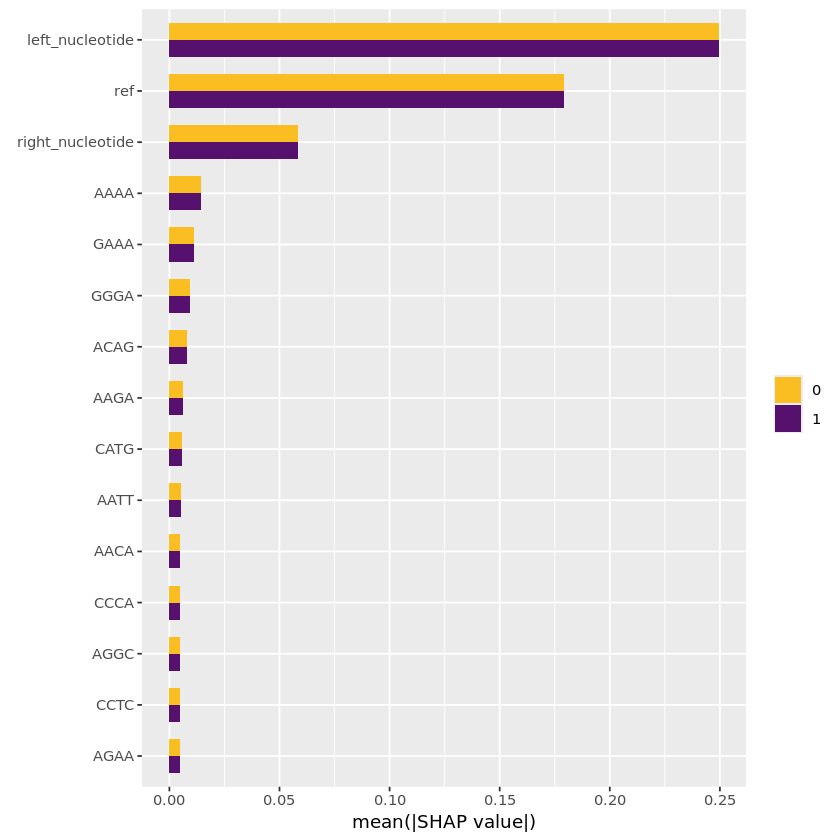

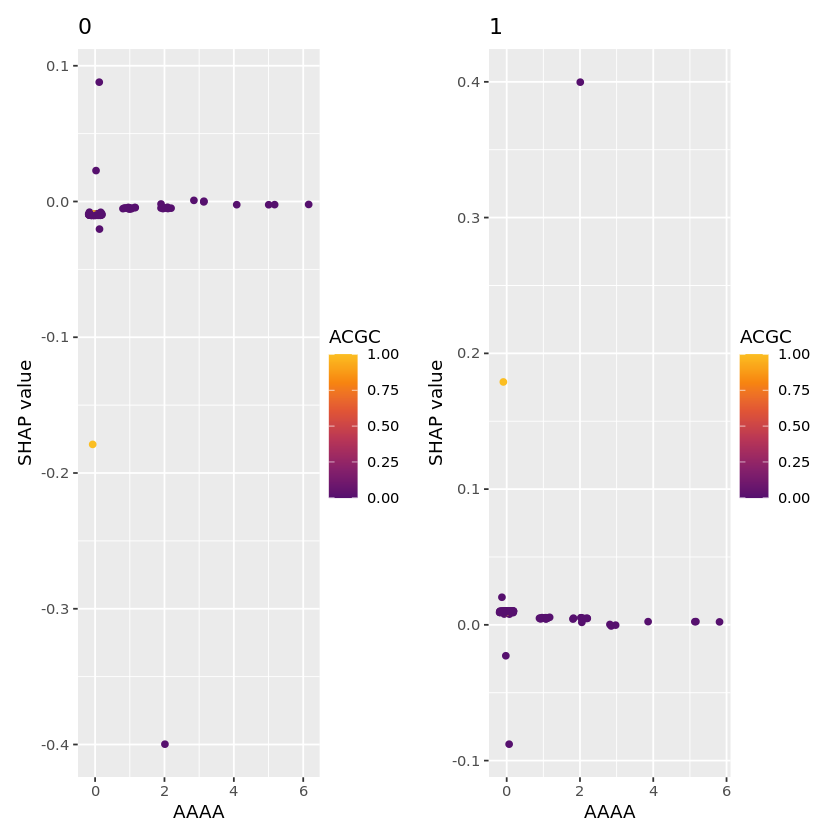

In [9]:
# Fitting the model
fit <- ranger(as.factor(y_train) ~ ., data = X_train, num.trees = 100)  # Reduce number of trees for faster training

# Model predictions and evaluation
y_pred <- predict(fit, X_test)$predictions
accuracy <- mean(y_pred == y_test)
print(paste("Accuracy:", accuracy))

# Replace numerical levels with signature labels in y_test and y_pred
signature_labels <- c("SBS04", "SBS13")
y_test_labels <- factor(signature_labels[y_test + 1], levels = signature_labels)
y_pred_labels <- factor(signature_labels[as.numeric(y_pred)], levels = signature_labels)

# Output the classification report with signature labels
print("Classification Report:")
print(table(y_test_labels, y_pred_labels))

# Select a smaller subset of X_train for bg_X
bg_X <- X_train[sample(seq_len(nrow(X_train)), size = 200), ]

# Select a smaller subset of X_test for SHAP calculation
X_test_subset <- X_test[sample(seq_len(nrow(X_test)), size = 100), ]

# Step 1: Calculate Kernel SHAP values
s <- kernelshap(fit, X_test_subset, bg_X = bg_X)

# Step 2: Turn them into a shapviz object
sv <- shapviz(s)

# Step 3: Gain insights
sv_importance(sv, kind = "bar")
sv_dependence(sv, v = "AAAA", color_var = "auto")

## Different Style
#sv_importance(sv, kind = "bee")
#sv_dependence(sv, v = "AAAA", color_var = "auto")

### Test the Model Again Without Ref

```ref```: mutation site, midlle nucleotide  
```alt```: the nucleotide that the orignal bp mutates to 

**The alt and ref with not be used for this model in order to compare with the all features model**  

```left_nucleotide```: the nucleotide on the left side of the mutation; part of the trinucleotide  
```right_nucleotide```: the nucleotide on the right side of the mutation; part of the trinucleotide  


In [10]:
# Function to extract the flanking nucleotides and the ref nucleotide
extract_features <- function(sequence) {
  n <- nchar(sequence)
  middle <- n %/% 2  # Assuming mutation site is in the middle
  left_flank_nucleotide <- substr(sequence, middle, middle)
  right_flank_nucleotide <- substr(sequence, middle + 2, middle + 2)
  return(c(left_flank_nucleotide, right_flank_nucleotide))
}

# Apply the function to extract the features for each row in the dataset
flanking_nucleotides <- t(apply(subset_data, 1, function(row) {
  extract_features(row["sequences"])
}))

# Convert the extracted features to a dataframe
flanking_nucleotides_df <- as.data.frame(flanking_nucleotides, stringsAsFactors = FALSE)
colnames(flanking_nucleotides_df) <- c("left_nucleotide", "right_nucleotide")

# Create the feature matrix
X <- as.data.frame(encoded_kmers)
X <- cbind(X, flanking_nucleotides_df)
head(X,10)

# Encode the flanking nucleotides and alt features as factors
X$left_nucleotide <- as.factor(X$left_nucleotide)
X$right_nucleotide <- as.factor(X$right_nucleotide)
# X$alt <- as.factor(X$alt)
# X$ref <- as.factor(X$ref)


# Encode the target variable
y <- as.integer(factor(subset_data$Signature, levels = c("SBS04", "SBS13"))) - 1  # Encode SBS04 as 0 and SBS13 as 1

# Split data into train and test sets
set.seed(2024)  # for reproducibility
train_indices <- sample(seq_len(nrow(X)), size = 0.8 * nrow(X))
X_train <- X[train_indices, ]
y_train <- y[train_indices]
X_test <- X[-train_indices, ]
y_test <- y[-train_indices]


,AGAG,TAGA,ATAG,AATA,ATTC,AGAA,GAGA,CTCC,GGGA,CCCG,...,ACGA,CGAC,CGAA,CGTA,CCGG,ACGT,TCGA,CGCG,left_nucleotide,right_nucleotide
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
744052,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,C,T
656950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,C,A
1387443,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,A,C
1137865,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,G,G
962943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,G,A
1148371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,G,G
938341,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,C,A
867574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,G,C
1777966,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,T,T


### Calculating SHAP Score

Growing trees.. Progress: 74%. Estimated remaining time: 10 seconds.
[1] "Accuracy: 0.784764991896272"
[1] "Classification Report:"
             y_pred_labels
y_test_labels SBS04 SBS13
        SBS04 13185  5246
        SBS13  2722 15867


Kernel SHAP values by the hybrid strategy of degree 1



  |======================================================================| 100%

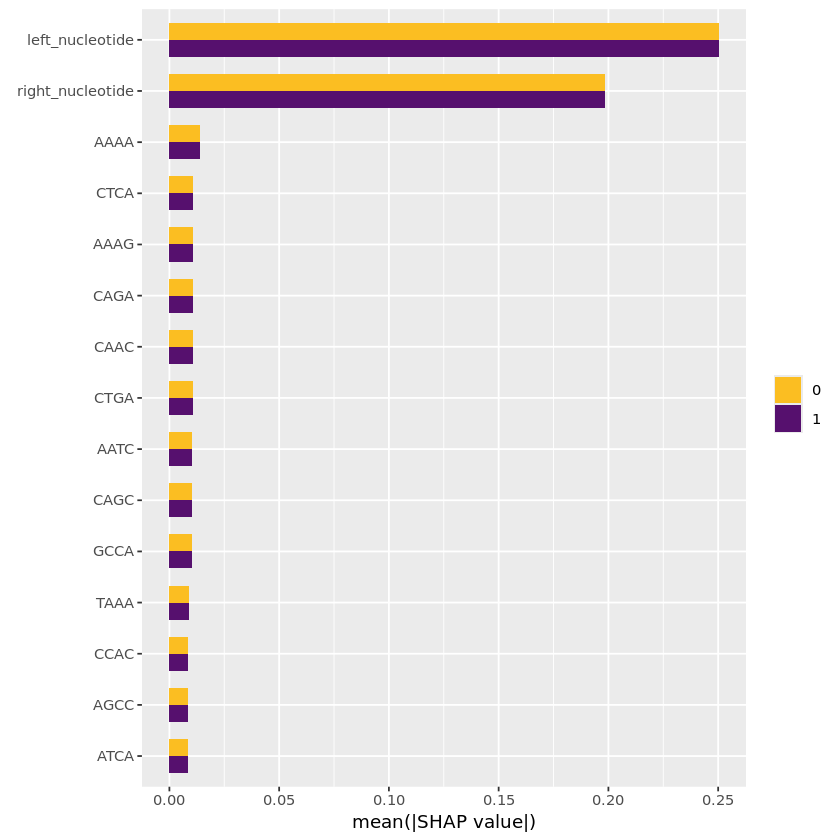

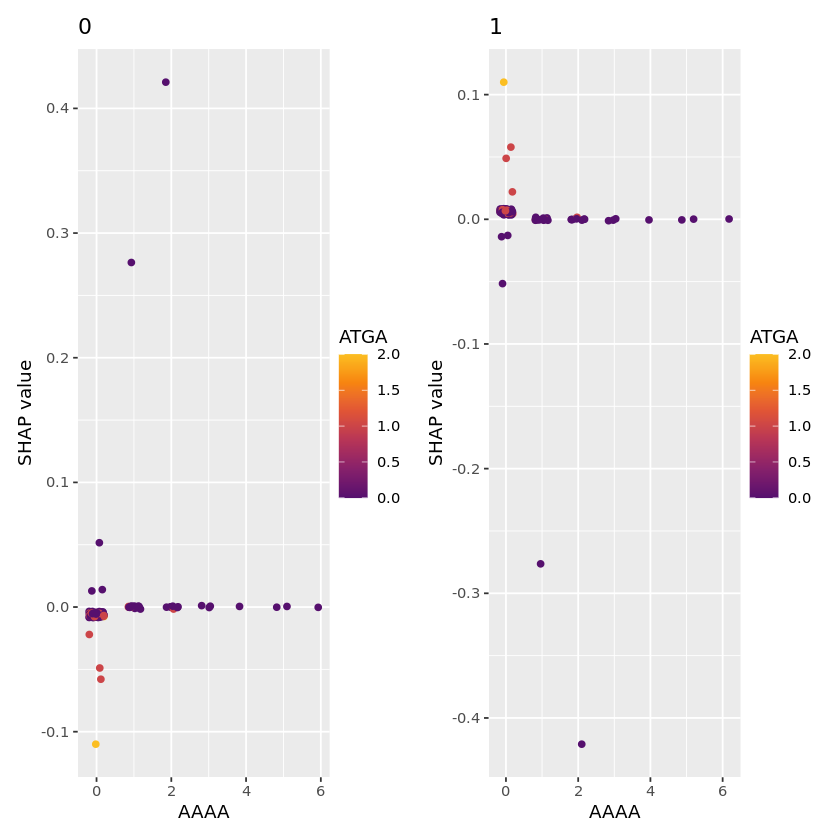

In [11]:
# Fitting the model
fit <- ranger(as.factor(y_train) ~ ., data = X_train, num.trees = 100)  # Reduce number of trees for faster training

# Model predictions and evaluation
y_pred <- predict(fit, X_test)$predictions
accuracy <- mean(y_pred == y_test)
print(paste("Accuracy:", accuracy))

# Replace numerical levels with signature labels in y_test and y_pred
signature_labels <- c("SBS04", "SBS13")
y_test_labels <- factor(signature_labels[y_test + 1], levels = signature_labels)
y_pred_labels <- factor(signature_labels[as.numeric(y_pred)], levels = signature_labels)

# Output the classification report with signature labels
print("Classification Report:")
print(table(y_test_labels, y_pred_labels))

# Select a smaller subset of X_train for bg_X
bg_X <- X_train[sample(seq_len(nrow(X_train)), size = 200), ]

# Select a smaller subset of X_test for SHAP calculation
X_test_subset <- X_test[sample(seq_len(nrow(X_test)), size = 100), ]

# Step 1: Calculate Kernel SHAP values
s <- kernelshap(fit, X_test_subset, bg_X = bg_X)

# Step 2: Turn them into a shapviz object
sv <- shapviz(s)

# Step 3: Gain insights
sv_importance(sv, kind = "bar")
sv_dependence(sv, v = "AAAA", color_var = "auto")

## Different Style
#sv_importance(sv, kind = "bee")
#sv_dependence(sv, v = "AAAA", color_var = "auto")